# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics

## How to use this notebook

### Local installation

1. Install required packages with `pip install -r requirements.txt` to your desired environment.
2. If a script version of this notebook is desired, comment (not uncomment) the first line of `nbconvert` cell.

### Colab installation

1.  Comment (not uncomment) the first line of the drive mounting cell.
2.  Comment (not uncomment) the first line of the `pip install` cell.

<!-- - For colab we also want to set the runtime to GPU by clicking _Change runtime_ in the _Runtime_ menu, and -->
<!-- - We want to wait for the google drive connection popup to appear and follow the instructions. -->

### Training without optimization

3. Set `OPTIMIZE = False` in section _Constants and flags to set_.
4. Run the entire notebook.

### Training with optimization

3. Set `OPTIMIZE = True` in section _Constants and flags to set_.
4. Run the entire notebook.

### Loading an already trained model

3. Run cells in section _Initialization_.
4. Run cells with definitions in section _Generating the data_.
5. Run cell with the definition of _Net_ in section _Defining the neural network_.
6. Make sure the `net.pth`, `optimizer.pth`, `scheduler.pth`, `var_dict.json` and `train_output.csv` files are in the directory containing this notebook.
7. Run the cells in section _Loading_ and continue from there.

### Generating the C++ model

8. Run section _Porting the model to C++_, this requires a model to be loaded.
9. Set the path to the `net.pt` file in the C++ source file.
10. `mkdir build && cd build`,
11. `cmake -DCMAKE_PREFIX_PATH=/path/to/libtorch/ ..`,
10. Compile and run, e.g. `cmake --build . --config release && ./executable`

## Initialization


Use this first cell to **convert this notebook** to a python script.

In [1]:
%%script echo skipping

!jupyter nbconvert five_parameter_run_1.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on **google colab**,

In [2]:
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")
# change this to your desired folder
drive_folder = "/content/drive/My Drive/bsc/con2prim_towards_GRMHD/five_parameter_run_1"

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [3]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


Importing the **libraries** and setting the **device**,

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Constants and flags to set
Defining some constants and parameters for convenience.

**NOTE**: Some **subparameters** still need to be adjusted in the `create_model` function itself as of (Tue May 16 07:42:45 AM CEST 2023).

In [6]:

N_TRIALS = 150 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

N_LAYERS_NO_OPT = 3
N_UNITS_NO_OPT = [555, 458, 115]
HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "Huber"
OPTIMIZER_NAME_NO_OPT = "RMSprop"
LR_NO_OPT = 0.000122770896701404
BATCH_SIZE_NO_OPT = 49
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, .57 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
vy_interval = (0, .57 * c) # Sampling interval for velocity in y-direction (used in sample_primitive_variables function)
vz_interval = (0, .57 * c) # Sampling interval for velocity in z-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(43) # Uncomment for pseudorandom data.


## Generating the data

In [7]:
# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have 
    # the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon



# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, vy, vz, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            vy is velocity in y-direction,
            vz is velocity in z-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst 
    # et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    vy = np.random.uniform(*vy_interval, size=n_samples)  # Velocity in y-direction
    vz = np.random.uniform(*vz_interval, size=n_samples)  # Velocity in z-direction 
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, vy, vz, epsilon



# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, vy, vz, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,)
        vy (torch.Tensor): The velocity in y-direction tensor of shape (n_samples,)
        vz (torch.Tensor): The velocity in z-direction tensor of shape (n_samples,)
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, Sy, Sz, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            Sy is conserved momentum in y-direction,
            Sz is conserved momentum in z-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

  # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    v2 = vx ** 2 + vy ** 2 + vz ** 2
    W = 1 / torch.sqrt(1 - v2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    Sy = rho * h * W ** 2 * vy  # Conserved momentum in y-direction
    Sz = rho * h * W ** 2 * vz  # Conserved momentum in z-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, Sy, Sz, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, vy, vz, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    vy = torch.tensor(vy, dtype=torch.float32).to(device)
    vz = torch.tensor(vz, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, Sy, Sz, tau = compute_conserved_variables(rho, vx, vy, vz, epsilon) 

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, Sy, Sz, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)
   
    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p


Sampling the primitive variables using the sample_primitive_variables function

In [8]:
rho_train, vx_train, vy_train, vz_train ,epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test ,vy_test ,vz_test ,epsilon_test = sample_primitive_variables(n_test_samples)

In [9]:
rho_train
vx_train
vy_train
vz_train 
epsilon_train
rho_test
vx_test 
vy_test 
vz_test 
epsilon_test

array([1.28762072, 1.9590914 , 0.58522533, ..., 0.06985293, 0.82055397,
       1.51444467])

In [10]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

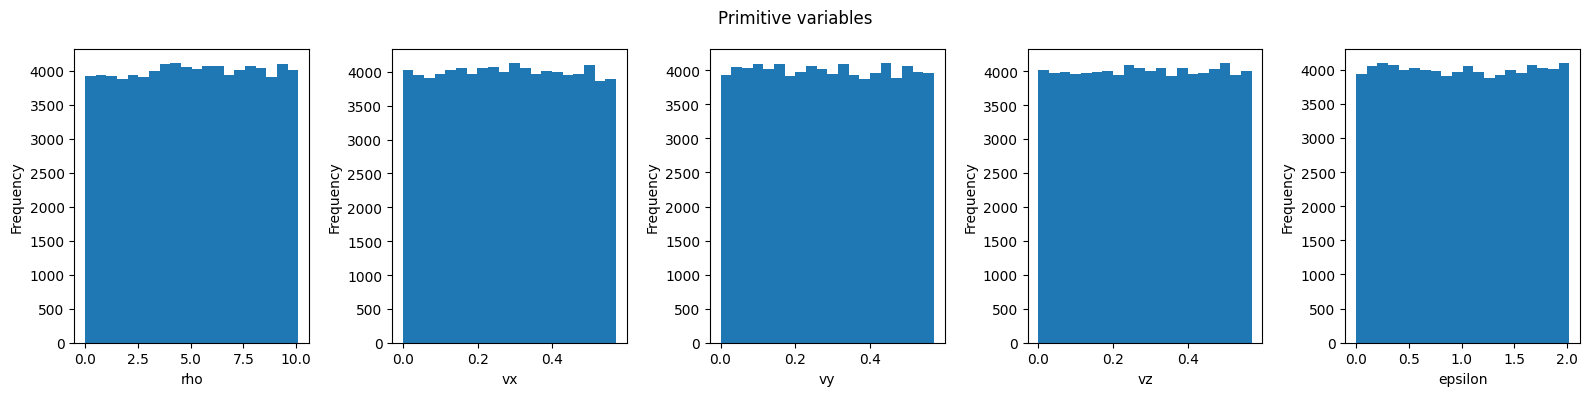

In [11]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(16, 4))
plt.subplot(1, 5, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 3)
plt.hist(vy_train, bins=20)
plt.xlabel("vy")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 4)
plt.hist(vz_train, bins=20)
plt.xlabel("vz")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 5)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [12]:
%config InteractiveShell.ast_node_interactivity = "all"

In [13]:
# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train ,vy_train, vz_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, vy_test, vz_test, epsilon_test)
y_test = generate_labels(rho_test, epsilon_test) 

In [14]:
x_train
y_train
x_test
y_test

tensor([[ 1.2253,  1.2439,  0.5428,  0.9811,  2.6203],
        [ 8.6760, 26.3492,  1.3128, 22.2189, 32.8612],
        [ 1.6644,  1.8987,  1.2941,  0.6595,  1.8787],
        ...,
        [ 0.8806,  0.3053,  0.6187,  1.1567,  1.7092],
        [ 9.4032,  9.6825,  9.5324, 16.1767, 22.2331],
        [ 4.6567,  2.9289,  0.3831,  2.7460,  8.2808]], device='cuda:0')

tensor([1.4350, 7.3753, 0.5281,  ..., 0.8335, 8.3240, 4.9954], device='cuda:0')

tensor([[1.0324e+01, 7.6037e+00, 4.1150e+00, 7.3877e+00, 1.5725e+01],
        [6.1274e+00, 8.8058e+00, 1.2547e+01, 1.0761e+01, 1.9520e+01],
        [2.8945e+00, 7.2054e-01, 2.6138e+00, 1.5800e+00, 2.6378e+00],
        ...,
        [1.0343e+00, 9.6165e-03, 8.6076e-02, 6.1373e-02, 7.7322e-02],
        [8.6855e+00, 1.3404e+00, 1.4288e+01, 9.4060e+00, 1.4448e+01],
        [1.1708e+01, 1.1230e+01, 2.6180e+01, 2.4258e+00, 2.8773e+01]],
       device='cuda:0')

tensor([8.3647, 6.5048, 0.9900,  ..., 0.0480, 3.6481, 9.7164], device='cuda:0')

In [15]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

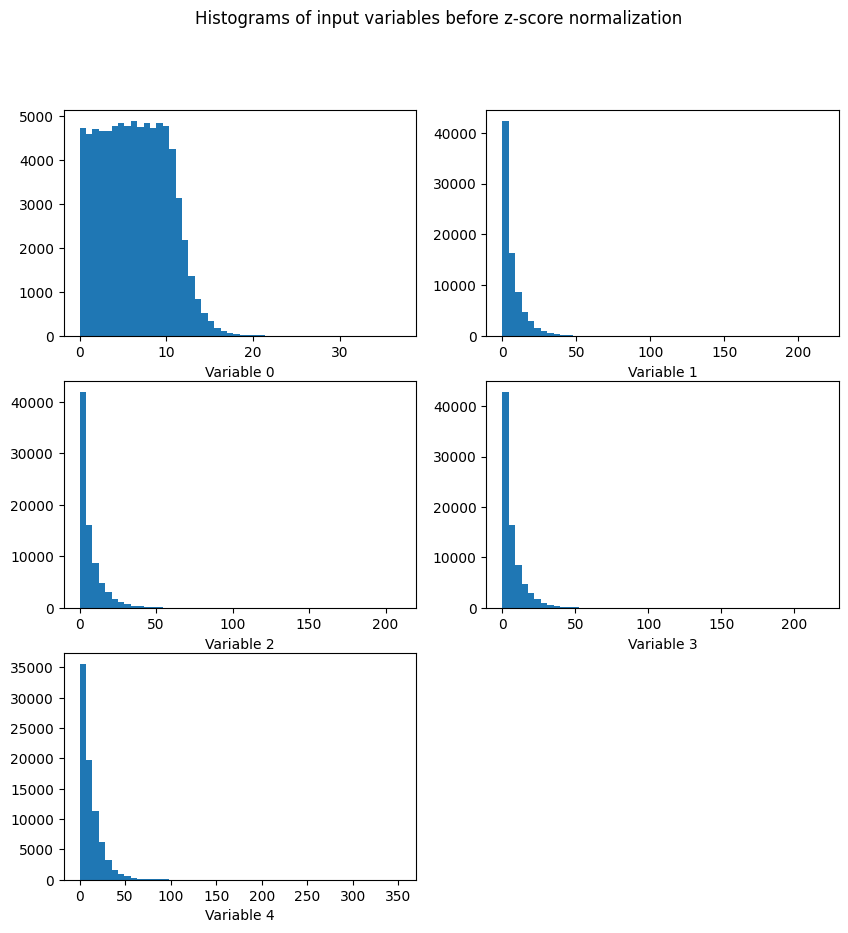

In [16]:
# Note how we are only plotting train and not test here. 
# Plotting histograms of the input variables before z-score normalization
plt.figure(figsize=(10, 10))
plt.suptitle('Histograms of input variables before z-score normalization')
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.hist(x_train[:, i].cpu(), bins=50) # Must be converted to cpu() for plotting.
    plt.xlabel(f'Variable {i}')
plt.show()


In [17]:
# print('Summary statistics of input variables before z-score normalization')
# print(torch.stack([torch.min(x_train, dim=0).values,
#                 torch.max(x_train, dim=0).values,
#                 torch.mean(x_train, dim=0),
#                 torch.median(x_train, dim=0).values,
#                 torch.std(x_train, dim=0)], dim=1))

# Computing summary statistics of the input variables before and after z-score normalization
print('Summary statistics of input variables before z-score normalization')
print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.nanmean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))

Summary statistics of input variables before z-score normalization
tensor([[2.0201e-04, 3.6966e+01, 6.3568e+00, 6.2493e+00, 3.8162e+00],
        [1.7208e-05, 2.1647e+02, 6.8448e+00, 3.8932e+00, 8.7775e+00],
        [2.1043e-05, 2.0937e+02, 6.8447e+00, 3.8528e+00, 8.7732e+00],
        [3.4876e-05, 2.1949e+02, 6.8660e+00, 3.8964e+00, 8.7893e+00],
        [6.3357e-05, 3.5165e+02, 1.2107e+01, 8.2963e+00, 1.3245e+01]],
       device='cuda:0')


Perform z-score normalization

In [18]:
%config InteractiveShell.ast_node_interactivity = "all"

In [19]:
if ZSCORE_NORMALIZATION:
    
    # # Computing the median of each input variable from the training set using torch.nanmedian function
    # D_median = torch.nanmedian(x_train[:, 0])
    # Sx_median = torch.nanmedian(x_train[:, 1])
    # Sy_median = torch.nanmedian(x_train[:, 2])
    # Sz_median = torch.nanmedian(x_train[:, 3])
    # tau_median = torch.nanmedian(x_train[:, 4])

    # # Computing the standard deviation of each input variable from the training set using torch.std function with a boolean mask to ignore nan values
    # D_std = torch.std(x_train[~torch.isnan(x_train[:, 0]), 0])
    # Sx_std = torch.std(x_train[~torch.isnan(x_train[:, 1]), 1])
    # Sy_std = torch.std(x_train[~torch.isnan(x_train[:, 2]), 2])
    # Sz_std = torch.std(x_train[~torch.isnan(x_train[:, 3]), 3])
    # tau_std = torch.std(x_train[~torch.isnan(x_train[:, 4]), 4])


    # # Applying z-score normalization to both train and test sets using the statistics from the training set
    # x_train[:, 0] = torch.sub(x_train[:, 0], D_median).div(D_std)
    # x_train[:, 1] = torch.sub(x_train[:, 1], Sx_median).div(Sx_std)
    # x_train[:, 2] = torch.sub(x_train[:, 2], Sy_median).div(Sy_std)
    # x_train[:, 3] = torch.sub(x_train[:, 3], Sz_median).div(Sz_std)
    # x_train[:, 4] = torch.sub(x_train[:, 4], tau_median).div(tau_std)

    # x_test[:, 0] = torch.sub(x_test[:, 0], D_median).div(D_std)
    # x_test[:, 1] = torch.sub(x_test[:, 1], Sx_median).div(Sx_std)
    # x_test[:, 2] = torch.sub(x_test[:, 2], Sy_median).div(Sy_std)
    # x_test[:, 3] = torch.sub(x_test[:, 3], Sz_median).div(Sz_std)
    # x_test[:, 4] = torch.sub(x_test[:, 4], tau_median).div(tau_std)

    # Computing the mean and standard deviation of each column
    mean = x_train.mean(dim=0)
    std = x_train.std(dim=0)

    # Applying z-score normalization
    x_train = (x_train - mean) / std
    # Use the same mean and std from the training data as we don't want test data leakage.
    x_test = (x_test - mean) / std



In [20]:
torch.__version__

'2.0.1+cu118'

In [21]:
x_train[:, 0]
x_train.shape
x_train
x_test

tensor([1.2253, 8.6760, 1.6644,  ..., 0.8806, 9.4032, 4.6567], device='cuda:0')

torch.Size([80000, 5])

tensor([[ 1.2253,  1.2439,  0.5428,  0.9811,  2.6203],
        [ 8.6760, 26.3492,  1.3128, 22.2189, 32.8612],
        [ 1.6644,  1.8987,  1.2941,  0.6595,  1.8787],
        ...,
        [ 0.8806,  0.3053,  0.6187,  1.1567,  1.7092],
        [ 9.4032,  9.6825,  9.5324, 16.1767, 22.2331],
        [ 4.6567,  2.9289,  0.3831,  2.7460,  8.2808]], device='cuda:0')

tensor([[1.0324e+01, 7.6037e+00, 4.1150e+00, 7.3877e+00, 1.5725e+01],
        [6.1274e+00, 8.8058e+00, 1.2547e+01, 1.0761e+01, 1.9520e+01],
        [2.8945e+00, 7.2054e-01, 2.6138e+00, 1.5800e+00, 2.6378e+00],
        ...,
        [1.0343e+00, 9.6165e-03, 8.6076e-02, 6.1373e-02, 7.7322e-02],
        [8.6855e+00, 1.3404e+00, 1.4288e+01, 9.4060e+00, 1.4448e+01],
        [1.1708e+01, 1.1230e+01, 2.6180e+01, 2.4258e+00, 2.8773e+01]],
       device='cuda:0')

Plotting the histograms of the input data after normalization if z-score normalization was performed.

In [22]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [23]:
if ZSCORE_NORMALIZATION: 
    # Note how we are only plotting train and not test here.
    # Plotting histograms of the input variables after z-score normalization
    plt.figure(figsize=(10, 10))
    plt.suptitle('Histograms of input variables after z-score normalization')
    for i in range(5):
        plt.subplot(3, 2, i+1)
        plt.hist(x_train[:, i].cpu(), bins=50) # Must be convertedhere to cpu() for plotting.
        plt.xlabel(f'Variable {i}')
    plt.show()

In [24]:
if ZSCORE_NORMALIZATION:
    # print('Summary statistics of input variables after z-score normalization')
    # print(torch.stack([torch.min(x_train, dim=0).values,
    #                 torch.max(x_train, dim=0).values,
    #                 torch.mean(x_train, dim=0),
    #                 torch.median(x_train, dim=0).values,
    #                 torch.std(x_train, dim=0)], dim=1))
    # Computing summary statistics of the input variables after z-score normalization
    print('Summary statistics of input variables after z-score normalization')
    print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.mean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))


Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 

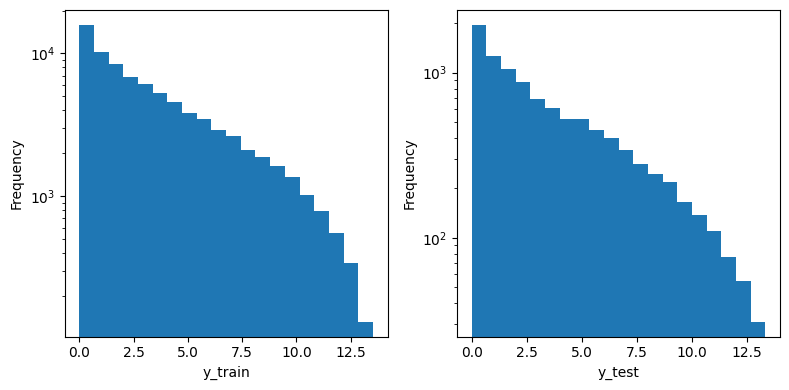

In [25]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [26]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [27]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(5, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 5).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Adding an assertion to check that the input tensor has the expected shape and type
        assert isinstance(x, torch.Tensor), "x must be a torch.Tensor"
        assert x.shape[1] == 5, "x must have shape (batch_size, 5)"

        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x


## Defining the model and search space

In [28]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 2, 6)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 2048) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            #"hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
            #"hidden_activation", ["ReLU", "LeakyReLU"]
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            #"output_activation", ["ReLU", "Softplus", "Linear"]
            "output_activation", ["ReLU", "Linear"]
        ) 
        loss_name = trial.suggest_categorical(
            #"loss", ["MSE", "MAE", "Huber", "LogCosh"] 
            "loss", ["MSE", "MAE", "Huber"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 

        batch_size_list = [32, 48, 64, 96, 128, 256, 512, 1048]
        batch_size = trial.suggest_categorical("batch_size", batch_size_list)
        #batch_size = trial.suggest_int("batch_size", 64, 1048)
        n_epochs = trial.suggest_int("n_epochs", 100, 300) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            # ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
            ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    if optimize:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            # Added sampling the weight decay and momentum for SGD
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            # Added sampling the weight decay and beta parameters for Adam
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
            beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.1, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            if n_epochs < 150:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
            elif n_epochs > 250:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
            else:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)

            T_max = int(n_epochs * t_max_fraction)
            eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added sampling the factor, patience and threshold for ReduceLROnPlateau
            factor = trial.suggest_uniform("factor", 0.1, 0.5)
            patience = trial.suggest_int("patience", 5, 10)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        # # Added using OneCycleLR scheduler as an option
        # elif scheduler_name == "OneCycleLR":
        #         # Added sampling the max_lr and pct_start for OneCycleLR
        #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
        #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer,
        #             max_lr=max_lr,
        #             epochs=n_epochs,
        #             steps_per_epoch=len(train_loader),
        #             pct_start=pct_start,
        #         )
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer)
        elif scheduler_name == "ReduceLROnPlateau":
            # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
            #)
            # Use Dieseldorst et al. settings and add to that a minimum lr.
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.18979341786654758, patience=11, threshold=0.0017197466122611932 #, min_lr=1e-6
                    )
        else:
            scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [29]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [30]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [31]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-21 15:32:15,049] A new study created in memory with name: no-name-b54c3748-34c2-4f3a-b23d-23d6641209e5
<ipython-input-28-e8f6ba3279cc>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-28-e8f6ba3279cc>:121: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-28-e8f6ba3279cc>:122: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  mom

Epoch 1: Train Loss: 0.3165, Test Loss: 0.0184, Train L1 Norm: 2.3224, Test L1 Norm: 0.3861, Train Linf Norm: 874.1108, Test Linf Norm: 79.0132
Epoch 2: Train Loss: 0.0156, Test Loss: 0.0268, Train L1 Norm: 0.7670, Test L1 Norm: 0.2097, Train Linf Norm: 305.5545, Test Linf Norm: 39.8496
Epoch 3: Train Loss: 0.0142, Test Loss: 0.0022, Train L1 Norm: 0.7132, Test L1 Norm: 0.1725, Train Linf Norm: 236.9826, Test Linf Norm: 37.1178
Epoch 4: Train Loss: 0.0083, Test Loss: 0.0027, Train L1 Norm: 0.6105, Test L1 Norm: 0.1885, Train Linf Norm: 253.8516, Test Linf Norm: 41.8405
Epoch 5: Train Loss: 0.0048, Test Loss: 0.0050, Train L1 Norm: 0.5645, Test L1 Norm: 0.1641, Train Linf Norm: 235.7162, Test Linf Norm: 36.3796
Epoch 6: Train Loss: 0.0089, Test Loss: 0.0027, Train L1 Norm: 0.5473, Test L1 Norm: 0.1560, Train Linf Norm: 224.1416, Test Linf Norm: 35.3218
Epoch 7: Train Loss: 0.0081, Test Loss: 0.0018, Train L1 Norm: 0.5274, Test L1 Norm: 0.1618, Train Linf Norm: 214.8692, Test Linf Norm: 

[I 2023-05-21 15:36:35,812] Trial 0 finished with value: 0.03574055362939835 and parameters: {'n_layers': 3, 'n_units_0': 365, 'n_units_1': 854, 'n_units_2': 1151, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 0.0032542528502947916, 'batch_size': 512, 'n_epochs': 226, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 1.2725271593905619e-05, 'momentum': 0.9437574684803857, 't_max_fraction': 0.1509152001515959, 'eta_min': 0.00013935524070238977}. Best is trial 0 with value: 0.03574055362939835.


Epoch 226: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0960, Test L1 Norm: 0.0357, Train Linf Norm: 37.5839, Test Linf Norm: 7.9498


<ipython-input-28-e8f6ba3279cc>:139: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.1, 0.5)


Epoch 1: Train Loss: 114.3778, Test Loss: 3.4549, Train L1 Norm: 100.0016, Test L1 Norm: 1.0000, Train Linf Norm: 11473.8515, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 3.4098, Test Loss: 3.4549, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 3.4098, Test Loss: 3.4549, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 3.4098, Test Loss: 3.4549, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 3.4098, Test Loss: 3.4549, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 3.4098, Test Loss: 3.4549, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 3.4098, Test Loss: 3.4549, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch

[I 2023-05-21 15:40:21,400] Trial 1 finished with value: 1.0 and parameters: {'n_layers': 3, 'n_units_0': 1076, 'n_units_1': 773, 'n_units_2': 86, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.006365015122318576, 'batch_size': 1048, 'n_epochs': 209, 'scheduler': 'StepLR', 'step_size': 9, 'gamma': 0.4842299174922722}. Best is trial 0 with value: 0.03574055362939835.


Epoch 209: Train Loss: 3.4098, Test Loss: 3.4549, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


<ipython-input-28-e8f6ba3279cc>:126: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-28-e8f6ba3279cc>:127: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
<ipython-input-28-e8f6ba3279cc>:128: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)


Epoch 1: Train Loss: 4.1978, Test Loss: 3.0087, Train L1 Norm: 18.5197, Test L1 Norm: 1.0000, Train Linf Norm: 1076.0963, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.9638, Test Loss: 3.0087, Train L1 Norm: 1.0211, Test L1 Norm: 1.0000, Train Linf Norm: 2.3518, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 2.9636, Test Loss: 3.0087, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.9636, Test Loss: 3.0087, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.9641, Test Loss: 3.0087, Train L1 Norm: 1.0033, Test L1 Norm: 1.0000, Train Linf Norm: 1.2137, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.9636, Test Loss: 3.0087, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 2.9637, Test Loss: 3.0087, Train L1 Norm: 1.0001, Test L1 Norm: 1.0000, Train Linf Norm: 1.0092, Test Linf Norm: 1.0000
Epoch 8: 

[I 2023-05-21 16:14:31,316] Trial 2 finished with value: 0.29505610167980195 and parameters: {'n_layers': 4, 'n_units_0': 1667, 'n_units_1': 1807, 'n_units_2': 1576, 'n_units_3': 857, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.005313437330538165, 'batch_size': 64, 'n_epochs': 287, 'scheduler': 'StepLR', 'weight_decay': 0.00018220191095773226, 'beta1': 0.9769970678001817, 'beta2': 0.9995286378678427, 'step_size': 11, 'gamma': 0.3384850447450514}. Best is trial 0 with value: 0.03574055362939835.


Epoch 287: Train Loss: 0.1761, Test Loss: 0.1787, Train L1 Norm: 0.3054, Test L1 Norm: 0.2951, Train Linf Norm: 5.5402, Test Linf Norm: 5.1552


<ipython-input-28-e8f6ba3279cc>:157: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.5)
<ipython-input-28-e8f6ba3279cc>:159: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1: Train Loss: 0.0995, Test Loss: 0.1855, Train L1 Norm: 0.2442, Test L1 Norm: 0.2235, Train Linf Norm: 19.6973, Test Linf Norm: 2.0883
Epoch 2: Train Loss: 0.0156, Test Loss: 0.0377, Train L1 Norm: 0.1074, Test L1 Norm: 0.1222, Train Linf Norm: 6.2133, Test Linf Norm: 2.8156
Epoch 3: Train Loss: 0.0103, Test Loss: 0.0075, Train L1 Norm: 0.0982, Test L1 Norm: 0.0714, Train Linf Norm: 7.5515, Test Linf Norm: 5.6198
Epoch 4: Train Loss: 0.0133, Test Loss: 0.0054, Train L1 Norm: 0.0959, Test L1 Norm: 0.0670, Train Linf Norm: 7.2946, Test Linf Norm: 3.9030
Epoch 5: Train Loss: 0.0065, Test Loss: 0.0038, Train L1 Norm: 0.1503, Test L1 Norm: 0.0749, Train Linf Norm: 25.8867, Test Linf Norm: 8.0659
Epoch 6: Train Loss: 0.0071, Test Loss: 0.0037, Train L1 Norm: 0.1052, Test L1 Norm: 0.0523, Train Linf Norm: 14.8369, Test Linf Norm: 4.9674
Epoch 7: Train Loss: 0.0079, Test Loss: 0.0774, Train L1 Norm: 0.0845, Test L1 Norm: 0.2218, Train Linf Norm: 10.2916, Test Linf Norm: 16.1360
Epoch 8:

[I 2023-05-21 16:18:40,213] Trial 3 finished with value: 0.028729132837057112 and parameters: {'n_layers': 3, 'n_units_0': 1148, 'n_units_1': 855, 'n_units_2': 42, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.00037336346060584007, 'batch_size': 256, 'n_epochs': 163, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.0030629480995270843, 'beta1': 0.9134952507504207, 'beta2': 0.9997704130618683, 'factor': 0.34962558510865055, 'patience': 10, 'threshold': 0.00412574764640008}. Best is trial 3 with value: 0.028729132837057112.


Epoch 163: Train Loss: 0.0008, Test Loss: 0.0011, Train L1 Norm: 0.0434, Test L1 Norm: 0.0287, Train Linf Norm: 6.7534, Test Linf Norm: 3.0556
Epoch 1: Train Loss: 1.3407, Test Loss: 0.9171, Train L1 Norm: 4.6354, Test L1 Norm: 1.4682, Train Linf Norm: 1714.2988, Test Linf Norm: 226.7664
Epoch 2: Train Loss: 0.4724, Test Loss: 0.2700, Train L1 Norm: 2.6557, Test L1 Norm: 0.3676, Train Linf Norm: 1073.2926, Test Linf Norm: 70.4574
Epoch 3: Train Loss: 0.2268, Test Loss: 0.1511, Train L1 Norm: 0.8008, Test L1 Norm: 0.2791, Train Linf Norm: 293.5904, Test Linf Norm: 58.0147
Epoch 4: Train Loss: 0.2520, Test Loss: 0.2520, Train L1 Norm: 0.6730, Test L1 Norm: 0.2614, Train Linf Norm: 225.5951, Test Linf Norm: 48.8976
Epoch 5: Train Loss: 0.2111, Test Loss: 0.2134, Train L1 Norm: 0.5827, Test L1 Norm: 0.3044, Train Linf Norm: 202.2112, Test Linf Norm: 54.9352
Epoch 6: Train Loss: 0.2194, Test Loss: 0.1260, Train L1 Norm: 0.5651, Test L1 Norm: 0.2347, Train Linf Norm: 187.4056, Test Linf Norm

[I 2023-05-21 16:25:30,717] Trial 4 finished with value: 0.05496781919002533 and parameters: {'n_layers': 4, 'n_units_0': 972, 'n_units_1': 1712, 'n_units_2': 1095, 'n_units_3': 714, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0004510263165822516, 'batch_size': 512, 'n_epochs': 295, 'scheduler': 'StepLR', 'weight_decay': 0.009818278377634463, 'momentum': 0.6691393537369812, 'step_size': 13, 'gamma': 0.4612246456460004}. Best is trial 3 with value: 0.028729132837057112.


Epoch 295: Train Loss: 0.0124, Test Loss: 0.0131, Train L1 Norm: 0.1272, Test L1 Norm: 0.0550, Train Linf Norm: 48.2084, Test Linf Norm: 12.2360
Epoch 1: Train Loss: 3.0184, Test Loss: 3.0087, Train L1 Norm: 1.0213, Test L1 Norm: 1.0000, Train Linf Norm: 1.1076, Test Linf Norm: 1.0000


[I 2023-05-21 16:25:41,807] Trial 5 pruned. 


Epoch 2: Train Loss: 2.9636, Test Loss: 3.0087, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.4383, Test Loss: 0.0124, Train L1 Norm: 2.5217, Test L1 Norm: 0.2758, Train Linf Norm: 1811.5481, Test Linf Norm: 90.3496
Epoch 2: Train Loss: 0.0063, Test Loss: 0.0067, Train L1 Norm: 0.7244, Test L1 Norm: 0.2141, Train Linf Norm: 557.0939, Test Linf Norm: 78.4897
Epoch 3: Train Loss: 0.0047, Test Loss: 0.0019, Train L1 Norm: 0.6308, Test L1 Norm: 0.1658, Train Linf Norm: 510.7414, Test Linf Norm: 63.1042
Epoch 4: Train Loss: 0.0037, Test Loss: 0.0041, Train L1 Norm: 0.5429, Test L1 Norm: 0.1723, Train Linf Norm: 431.7121, Test Linf Norm: 63.6761
Epoch 5: Train Loss: 0.0051, Test Loss: 0.0065, Train L1 Norm: 0.5677, Test L1 Norm: 0.1886, Train Linf Norm: 458.2724, Test Linf Norm: 68.7944
Epoch 6: Train Loss: 0.0062, Test Loss: 0.0010, Train L1 Norm: 0.6019, Test L1 Norm: 0.1531, Train Linf Norm: 497.1396, Test Linf Norm: 60

[I 2023-05-21 16:26:02,466] Trial 6 pruned. 


Epoch 11: Train Loss: 0.0025, Test Loss: 0.0018, Train L1 Norm: 0.5606, Test L1 Norm: 0.1672, Train Linf Norm: 366.0774, Test Linf Norm: 66.0232
Epoch 1: Train Loss: 0.3187, Test Loss: 0.0390, Train L1 Norm: 1.2747, Test L1 Norm: 0.2800, Train Linf Norm: 34.0333, Test Linf Norm: 5.7621
Epoch 2: Train Loss: 0.0595, Test Loss: 0.0339, Train L1 Norm: 0.6312, Test L1 Norm: 0.1775, Train Linf Norm: 17.4347, Test Linf Norm: 3.2373
Epoch 3: Train Loss: 0.0397, Test Loss: 0.0142, Train L1 Norm: 0.4660, Test L1 Norm: 0.1156, Train Linf Norm: 12.8877, Test Linf Norm: 2.1836
Epoch 4: Train Loss: 0.0243, Test Loss: 0.0121, Train L1 Norm: 0.3546, Test L1 Norm: 0.1131, Train Linf Norm: 9.5643, Test Linf Norm: 2.1302
Epoch 5: Train Loss: 0.0249, Test Loss: 0.0082, Train L1 Norm: 0.4132, Test L1 Norm: 0.1016, Train Linf Norm: 11.3554, Test Linf Norm: 1.9380
Epoch 6: Train Loss: 0.0182, Test Loss: 0.0068, Train L1 Norm: 0.4242, Test L1 Norm: 0.0964, Train Linf Norm: 12.0465, Test Linf Norm: 1.8788
Epoc

[I 2023-05-21 16:30:29,043] Trial 7 pruned. 


Epoch 30: Train Loss: 0.0040, Test Loss: 0.0040, Train L1 Norm: 0.3509, Test L1 Norm: 0.0898, Train Linf Norm: 10.1486, Test Linf Norm: 1.7958


<ipython-input-28-e8f6ba3279cc>:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)


Epoch 1: Train Loss: 0.3429, Test Loss: 0.0481, Train L1 Norm: 0.7170, Test L1 Norm: 0.1558, Train Linf Norm: 34.4950, Test Linf Norm: 7.0103
Epoch 2: Train Loss: 0.0597, Test Loss: 0.0994, Train L1 Norm: 0.2729, Test L1 Norm: 0.1074, Train Linf Norm: 15.1596, Test Linf Norm: 3.9288
Epoch 3: Train Loss: 0.0549, Test Loss: 0.1197, Train L1 Norm: 0.3068, Test L1 Norm: 0.0763, Train Linf Norm: 17.6044, Test Linf Norm: 1.3947
Epoch 4: Train Loss: 0.0500, Test Loss: 0.0586, Train L1 Norm: 0.1580, Test L1 Norm: 0.0731, Train Linf Norm: 8.2252, Test Linf Norm: 2.6138
Epoch 5: Train Loss: 0.0504, Test Loss: 0.0341, Train L1 Norm: 0.1686, Test L1 Norm: 0.0600, Train Linf Norm: 9.0444, Test Linf Norm: 2.5244
Epoch 6: Train Loss: 0.0335, Test Loss: 0.0258, Train L1 Norm: 0.1032, Test L1 Norm: 0.0666, Train Linf Norm: 5.3626, Test Linf Norm: 2.9249
Epoch 7: Train Loss: 0.0352, Test Loss: 0.0323, Train L1 Norm: 0.1068, Test L1 Norm: 0.0355, Train Linf Norm: 5.5720, Test Linf Norm: 1.1477
Epoch 8: T

[I 2023-05-21 16:49:25,616] Trial 8 finished with value: 0.03349379635155201 and parameters: {'n_layers': 5, 'n_units_0': 2035, 'n_units_1': 430, 'n_units_2': 85, 'n_units_3': 249, 'n_units_4': 1180, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.007043416804254222, 'batch_size': 64, 'n_epochs': 266, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0003493490424421317, 'beta1': 0.9933071892518038, 'beta2': 0.9993400777217661, 't_max_fraction': 0.05198176896720075, 'eta_min': 1.7980843712441667e-06}. Best is trial 3 with value: 0.028729132837057112.


Epoch 266: Train Loss: 0.0212, Test Loss: 0.0175, Train L1 Norm: 0.0666, Test L1 Norm: 0.0335, Train Linf Norm: 3.4968, Test Linf Norm: 1.3741


[I 2023-05-21 16:49:29,485] Trial 9 pruned. 


Epoch 1: Train Loss: 21.4836, Test Loss: 21.1527, Train L1 Norm: 1.0222, Test L1 Norm: 1.0000, Train Linf Norm: 1.3500, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1769, Test Loss: 0.0323, Train L1 Norm: 0.5229, Test L1 Norm: 0.1229, Train Linf Norm: 73.8835, Test Linf Norm: 9.0341
Epoch 2: Train Loss: 0.0202, Test Loss: 0.0095, Train L1 Norm: 0.2233, Test L1 Norm: 0.0784, Train Linf Norm: 37.2328, Test Linf Norm: 6.1008
Epoch 3: Train Loss: 0.0107, Test Loss: 0.0064, Train L1 Norm: 0.2382, Test L1 Norm: 0.0590, Train Linf Norm: 46.5801, Test Linf Norm: 4.4207
Epoch 4: Train Loss: 0.0083, Test Loss: 0.0051, Train L1 Norm: 0.1599, Test L1 Norm: 0.0510, Train Linf Norm: 28.3492, Test Linf Norm: 3.5964
Epoch 5: Train Loss: 0.0056, Test Loss: 0.0044, Train L1 Norm: 0.1360, Test L1 Norm: 0.0581, Train Linf Norm: 24.0297, Test Linf Norm: 5.2185
Epoch 6: Train Loss: 0.0042, Test Loss: 0.0039, Train L1 Norm: 0.1907, Test L1 Norm: 0.0482, Train Linf Norm: 39.1278, Test Linf Norm: 3.7825
Epoch

[I 2023-05-21 16:51:49,142] Trial 10 finished with value: 0.023221840736269952 and parameters: {'n_layers': 2, 'n_units_0': 800, 'n_units_1': 98, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0013332181796177327, 'batch_size': 256, 'n_epochs': 101, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.19643578862292976, 'patience': 5, 'threshold': 0.008455502280580186}. Best is trial 10 with value: 0.023221840736269952.


Epoch 101: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0929, Test L1 Norm: 0.0232, Train Linf Norm: 19.6568, Test Linf Norm: 1.9857
Epoch 1: Train Loss: 0.1966, Test Loss: 0.0325, Train L1 Norm: 1.0383, Test L1 Norm: 0.1932, Train Linf Norm: 198.8742, Test Linf Norm: 20.0102
Epoch 2: Train Loss: 0.0227, Test Loss: 0.0147, Train L1 Norm: 0.3375, Test L1 Norm: 0.1141, Train Linf Norm: 63.1087, Test Linf Norm: 10.3718
Epoch 3: Train Loss: 0.0131, Test Loss: 0.0110, Train L1 Norm: 0.1775, Test L1 Norm: 0.0808, Train Linf Norm: 28.5769, Test Linf Norm: 6.5234
Epoch 4: Train Loss: 0.0086, Test Loss: 0.0098, Train L1 Norm: 0.1546, Test L1 Norm: 0.0734, Train Linf Norm: 25.9636, Test Linf Norm: 5.4000
Epoch 5: Train Loss: 0.0072, Test Loss: 0.0080, Train L1 Norm: 0.1181, Test L1 Norm: 0.0668, Train Linf Norm: 18.6639, Test Linf Norm: 5.1548
Epoch 6: Train Loss: 0.0062, Test Loss: 0.0048, Train L1 Norm: 0.0969, Test L1 Norm: 0.0515, Train Linf Norm: 14.1159, Test Linf Norm: 3.7479
E

[I 2023-05-21 16:54:12,425] Trial 11 finished with value: 0.025123866349458693 and parameters: {'n_layers': 2, 'n_units_0': 827, 'n_units_1': 63, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00137772584226203, 'batch_size': 256, 'n_epochs': 105, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.19073745483393878, 'patience': 5, 'threshold': 0.009017892774159462}. Best is trial 10 with value: 0.023221840736269952.


Epoch 105: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0466, Test L1 Norm: 0.0251, Train Linf Norm: 7.6260, Test Linf Norm: 2.1565
Epoch 1: Train Loss: 0.1586, Test Loss: 0.0199, Train L1 Norm: 0.4521, Test L1 Norm: 0.1135, Train Linf Norm: 59.4399, Test Linf Norm: 11.5630
Epoch 2: Train Loss: 0.0202, Test Loss: 0.0106, Train L1 Norm: 0.1902, Test L1 Norm: 0.0928, Train Linf Norm: 27.7440, Test Linf Norm: 8.8949
Epoch 3: Train Loss: 0.0106, Test Loss: 0.0088, Train L1 Norm: 0.1748, Test L1 Norm: 0.1015, Train Linf Norm: 29.9309, Test Linf Norm: 9.1101
Epoch 4: Train Loss: 0.0071, Test Loss: 0.0049, Train L1 Norm: 0.1131, Test L1 Norm: 0.0564, Train Linf Norm: 17.0507, Test Linf Norm: 4.7043
Epoch 5: Train Loss: 0.0055, Test Loss: 0.0061, Train L1 Norm: 0.0994, Test L1 Norm: 0.0665, Train Linf Norm: 14.3460, Test Linf Norm: 5.7706
Epoch 6: Train Loss: 0.0047, Test Loss: 0.0040, Train L1 Norm: 0.1011, Test L1 Norm: 0.0510, Train Linf Norm: 15.1657, Test Linf Norm: 4.4708
Epoc

[I 2023-05-21 16:56:33,430] Trial 12 finished with value: 0.027346139679849148 and parameters: {'n_layers': 2, 'n_units_0': 674, 'n_units_1': 86, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.001325400412007455, 'batch_size': 256, 'n_epochs': 103, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.18007484166371648, 'patience': 5, 'threshold': 0.007470674215215709}. Best is trial 10 with value: 0.023221840736269952.


Epoch 103: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0545, Test L1 Norm: 0.0273, Train Linf Norm: 9.6220, Test Linf Norm: 2.6965


[I 2023-05-21 16:56:34,616] Trial 13 pruned. 


Epoch 1: Train Loss: 1.1601, Test Loss: 0.7447, Train L1 Norm: 5.9875, Test L1 Norm: 1.9301, Train Linf Norm: 1189.5881, Test Linf Norm: 179.0095
Epoch 1: Train Loss: 0.2471, Test Loss: 0.0271, Train L1 Norm: 0.3651, Test L1 Norm: 0.0654, Train Linf Norm: 13.2264, Test Linf Norm: 1.2643
Epoch 2: Train Loss: 0.0168, Test Loss: 0.0117, Train L1 Norm: 0.1441, Test L1 Norm: 0.0553, Train Linf Norm: 5.4118, Test Linf Norm: 1.2640
Epoch 3: Train Loss: 0.0109, Test Loss: 0.0068, Train L1 Norm: 0.1447, Test L1 Norm: 0.0429, Train Linf Norm: 5.7423, Test Linf Norm: 1.0200
Epoch 4: Train Loss: 0.0056, Test Loss: 0.0043, Train L1 Norm: 0.1080, Test L1 Norm: 0.0358, Train Linf Norm: 4.1427, Test Linf Norm: 0.8321
Epoch 5: Train Loss: 0.0046, Test Loss: 0.0103, Train L1 Norm: 0.1052, Test L1 Norm: 0.0478, Train Linf Norm: 4.0797, Test Linf Norm: 1.0792
Epoch 6: Train Loss: 0.0038, Test Loss: 0.0029, Train L1 Norm: 0.0921, Test L1 Norm: 0.0339, Train Linf Norm: 3.5193, Test Linf Norm: 0.8247
Epoch 7

[I 2023-05-21 17:05:45,950] Trial 14 finished with value: 0.01707801818549633 and parameters: {'n_layers': 2, 'n_units_0': 871, 'n_units_1': 317, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.001016472444043591, 'batch_size': 48, 'n_epochs': 132, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.10586643362396991, 'patience': 6, 'threshold': 0.001997656486403879}. Best is trial 14 with value: 0.01707801818549633.


Epoch 132: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0535, Test L1 Norm: 0.0171, Train Linf Norm: 2.1912, Test Linf Norm: 0.4250
Epoch 1: Train Loss: 0.2224, Test Loss: 0.0258, Train L1 Norm: 0.3665, Test L1 Norm: 0.0727, Train Linf Norm: 13.9351, Test Linf Norm: 1.8374
Epoch 2: Train Loss: 0.0358, Test Loss: 0.0043, Train L1 Norm: 0.1537, Test L1 Norm: 0.0324, Train Linf Norm: 5.7567, Test Linf Norm: 0.6342
Epoch 3: Train Loss: 0.0087, Test Loss: 0.0042, Train L1 Norm: 0.1088, Test L1 Norm: 0.0308, Train Linf Norm: 4.2627, Test Linf Norm: 0.6876
Epoch 4: Train Loss: 0.0030, Test Loss: 0.0021, Train L1 Norm: 0.0695, Test L1 Norm: 0.0258, Train Linf Norm: 2.6078, Test Linf Norm: 0.5953
Epoch 5: Train Loss: 0.0044, Test Loss: 0.0024, Train L1 Norm: 0.0695, Test L1 Norm: 0.0220, Train Linf Norm: 2.6586, Test Linf Norm: 0.4666
Epoch 6: Train Loss: 0.0031, Test Loss: 0.0010, Train L1 Norm: 0.0454, Test L1 Norm: 0.0195, Train Linf Norm: 1.5623, Test Linf Norm: 0.4386
Epoch 7: T

[I 2023-05-21 17:17:13,084] Trial 15 finished with value: 0.012029853112623095 and parameters: {'n_layers': 3, 'n_units_0': 1362, 'n_units_1': 351, 'n_units_2': 2005, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0008106842863430457, 'batch_size': 48, 'n_epochs': 142, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.11930344331358568, 'patience': 7, 'threshold': 0.0016046377935483712}. Best is trial 15 with value: 0.012029853112623095.


Epoch 142: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0409, Test L1 Norm: 0.0120, Train Linf Norm: 1.7229, Test Linf Norm: 0.3190
Epoch 1: Train Loss: 0.2234, Test Loss: 0.0072, Train L1 Norm: 0.4709, Test L1 Norm: 0.0734, Train Linf Norm: 18.5457, Test Linf Norm: 1.9754
Epoch 2: Train Loss: 0.0121, Test Loss: 0.0060, Train L1 Norm: 0.1352, Test L1 Norm: 0.0419, Train Linf Norm: 5.1867, Test Linf Norm: 0.8887
Epoch 3: Train Loss: 0.0053, Test Loss: 0.0018, Train L1 Norm: 0.1003, Test L1 Norm: 0.0332, Train Linf Norm: 3.8278, Test Linf Norm: 0.7912
Epoch 4: Train Loss: 0.0036, Test Loss: 0.0014, Train L1 Norm: 0.0763, Test L1 Norm: 0.0325, Train Linf Norm: 2.8100, Test Linf Norm: 0.8447
Epoch 5: Train Loss: 0.0024, Test Loss: 0.0016, Train L1 Norm: 0.0718, Test L1 Norm: 0.0293, Train Linf Norm: 2.7091, Test Linf Norm: 0.7380
Epoch 6: Train Loss: 0.0019, Test Loss: 0.0009, Train L1 Norm: 0.0717, Test L1 Norm: 0.0265, Train Linf Norm: 2.7707, Test Linf Norm: 0.6699
Epoch 7: T

[I 2023-05-21 17:29:07,948] Trial 16 finished with value: 0.013775071762502193 and parameters: {'n_layers': 3, 'n_units_0': 1473, 'n_units_1': 411, 'n_units_2': 2033, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0007818966551590938, 'batch_size': 48, 'n_epochs': 148, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.1030434455196717, 'patience': 7, 'threshold': 0.001349970552397691}. Best is trial 15 with value: 0.012029853112623095.


Epoch 148: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0439, Test L1 Norm: 0.0138, Train Linf Norm: 1.8370, Test Linf Norm: 0.3853


<ipython-input-28-e8f6ba3279cc>:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
[I 2023-05-21 17:29:13,977] Trial 17 pruned. 


Epoch 1: Train Loss: 0.3537, Test Loss: 0.8034, Train L1 Norm: 0.3117, Test L1 Norm: 0.2869, Train Linf Norm: 10.5708, Test Linf Norm: 6.9467


[I 2023-05-21 17:29:19,258] Trial 18 pruned. 


Epoch 1: Train Loss: 7.3308, Test Loss: 0.0532, Train L1 Norm: 0.8228, Test L1 Norm: 0.2273, Train Linf Norm: 29.1991, Test Linf Norm: 6.0983


[I 2023-05-21 17:29:21,580] Trial 19 pruned. 


Epoch 1: Train Loss: 528.9861, Test Loss: 1.7041, Train L1 Norm: 4.5700, Test L1 Norm: 0.6001, Train Linf Norm: 436.6889, Test Linf Norm: 26.1516
Epoch 1: Train Loss: 0.3351, Test Loss: 0.0114, Train L1 Norm: 0.3794, Test L1 Norm: 0.0623, Train Linf Norm: 13.1267, Test Linf Norm: 1.4344
Epoch 2: Train Loss: 0.0092, Test Loss: 0.0042, Train L1 Norm: 0.0920, Test L1 Norm: 0.0360, Train Linf Norm: 3.1977, Test Linf Norm: 0.8066
Epoch 3: Train Loss: 0.0053, Test Loss: 0.0011, Train L1 Norm: 0.0895, Test L1 Norm: 0.0291, Train Linf Norm: 3.3616, Test Linf Norm: 0.7325
Epoch 4: Train Loss: 0.0045, Test Loss: 0.0011, Train L1 Norm: 0.0686, Test L1 Norm: 0.0244, Train Linf Norm: 2.5297, Test Linf Norm: 0.5871
Epoch 5: Train Loss: 0.0025, Test Loss: 0.0021, Train L1 Norm: 0.0500, Test L1 Norm: 0.0247, Train Linf Norm: 1.7391, Test Linf Norm: 0.5651
Epoch 6: Train Loss: 0.0022, Test Loss: 0.0005, Train L1 Norm: 0.0506, Test L1 Norm: 0.0262, Train Linf Norm: 1.7971, Test Linf Norm: 0.7307
Epoch 7

[I 2023-05-21 17:55:19,516] Trial 20 finished with value: 0.009307051534205675 and parameters: {'n_layers': 5, 'n_units_0': 1790, 'n_units_1': 1093, 'n_units_2': 1795, 'n_units_3': 1456, 'n_units_4': 118, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0009234706910236727, 'batch_size': 48, 'n_epochs': 191, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13437525790218866, 'eta_min': 1.0238006774822311e-07}. Best is trial 20 with value: 0.009307051534205675.


Epoch 191: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0132, Test L1 Norm: 0.0093, Train Linf Norm: 0.4286, Test Linf Norm: 0.2401


[I 2023-05-21 17:55:28,568] Trial 21 pruned. 


Epoch 1: Train Loss: 0.3412, Test Loss: 0.2021, Train L1 Norm: 0.9893, Test L1 Norm: 0.2825, Train Linf Norm: 40.9074, Test Linf Norm: 8.8176
Epoch 1: Train Loss: 0.3507, Test Loss: 0.0054, Train L1 Norm: 0.5275, Test L1 Norm: 0.1193, Train Linf Norm: 20.2205, Test Linf Norm: 3.7571
Epoch 2: Train Loss: 0.0098, Test Loss: 0.0020, Train L1 Norm: 0.3025, Test L1 Norm: 0.0828, Train Linf Norm: 12.8775, Test Linf Norm: 2.8244
Epoch 3: Train Loss: 0.0065, Test Loss: 0.0011, Train L1 Norm: 0.1728, Test L1 Norm: 0.0517, Train Linf Norm: 7.2091, Test Linf Norm: 1.6385
Epoch 4: Train Loss: 0.0037, Test Loss: 0.0008, Train L1 Norm: 0.1246, Test L1 Norm: 0.0427, Train Linf Norm: 5.1061, Test Linf Norm: 1.3305
Epoch 5: Train Loss: 0.0012, Test Loss: 0.0005, Train L1 Norm: 0.0921, Test L1 Norm: 0.0345, Train Linf Norm: 3.7112, Test Linf Norm: 1.0464
Epoch 6: Train Loss: 0.0066, Test Loss: 0.0009, Train L1 Norm: 0.0920, Test L1 Norm: 0.0367, Train Linf Norm: 3.6901, Test Linf Norm: 1.1531
Epoch 7: T

[I 2023-05-21 18:34:04,380] Trial 22 finished with value: 0.009334696703404187 and parameters: {'n_layers': 6, 'n_units_0': 1824, 'n_units_1': 2020, 'n_units_2': 2039, 'n_units_3': 1504, 'n_units_4': 682, 'n_units_5': 19, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0003853845869849074, 'batch_size': 48, 'n_epochs': 219, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.14067303973539794, 'eta_min': 1.3612508895327606e-07}. Best is trial 20 with value: 0.009307051534205675.


Epoch 219: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0166, Test L1 Norm: 0.0093, Train Linf Norm: 0.6034, Test Linf Norm: 0.2502


[I 2023-05-21 18:34:14,752] Trial 23 pruned. 


Epoch 1: Train Loss: 0.2660, Test Loss: 0.0061, Train L1 Norm: 0.6477, Test L1 Norm: 0.1435, Train Linf Norm: 25.9007, Test Linf Norm: 4.6882
Epoch 1: Train Loss: 0.2390, Test Loss: 0.0062, Train L1 Norm: 0.8786, Test L1 Norm: 0.1312, Train Linf Norm: 36.4884, Test Linf Norm: 4.2311
Epoch 2: Train Loss: 0.0106, Test Loss: 0.0017, Train L1 Norm: 0.1897, Test L1 Norm: 0.0470, Train Linf Norm: 7.4915, Test Linf Norm: 1.2865
Epoch 3: Train Loss: 0.0027, Test Loss: 0.0010, Train L1 Norm: 0.1003, Test L1 Norm: 0.0325, Train Linf Norm: 3.8614, Test Linf Norm: 0.8063
Epoch 4: Train Loss: 0.0046, Test Loss: 0.0008, Train L1 Norm: 0.1026, Test L1 Norm: 0.0328, Train Linf Norm: 4.0807, Test Linf Norm: 0.9309
Epoch 5: Train Loss: 0.0030, Test Loss: 0.0007, Train L1 Norm: 0.0870, Test L1 Norm: 0.0276, Train Linf Norm: 3.4601, Test Linf Norm: 0.7536
Epoch 6: Train Loss: 0.0025, Test Loss: 0.0006, Train L1 Norm: 0.0819, Test L1 Norm: 0.0260, Train Linf Norm: 3.2912, Test Linf Norm: 0.7259
Epoch 7: Tr

[I 2023-05-21 19:11:31,235] Trial 24 finished with value: 0.00859525605328381 and parameters: {'n_layers': 6, 'n_units_0': 1232, 'n_units_1': 2042, 'n_units_2': 1457, 'n_units_3': 1465, 'n_units_4': 625, 'n_units_5': 47, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0005138171230886355, 'batch_size': 48, 'n_epochs': 239, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.14112860634139976, 'eta_min': 1.5124586804607073e-06}. Best is trial 24 with value: 0.00859525605328381.


Epoch 239: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0234, Test L1 Norm: 0.0086, Train Linf Norm: 0.9450, Test Linf Norm: 0.2276
Epoch 1: Train Loss: 0.5555, Test Loss: 0.0094, Train L1 Norm: 0.5645, Test L1 Norm: 0.1310, Train Linf Norm: 38.8028, Test Linf Norm: 7.1574
Epoch 2: Train Loss: 0.0214, Test Loss: 0.0041, Train L1 Norm: 0.3151, Test L1 Norm: 0.0532, Train Linf Norm: 25.5621, Test Linf Norm: 2.4756
Epoch 3: Train Loss: 0.0051, Test Loss: 0.0019, Train L1 Norm: 0.1157, Test L1 Norm: 0.0415, Train Linf Norm: 8.4453, Test Linf Norm: 1.9757
Epoch 4: Train Loss: 0.0058, Test Loss: 0.0048, Train L1 Norm: 0.0879, Test L1 Norm: 0.0385, Train Linf Norm: 6.1360, Test Linf Norm: 1.5779
Epoch 5: Train Loss: 0.0046, Test Loss: 0.0022, Train L1 Norm: 0.0807, Test L1 Norm: 0.0467, Train Linf Norm: 5.8054, Test Linf Norm: 2.2582
Epoch 6: Train Loss: 0.0024, Test Loss: 0.0006, Train L1 Norm: 0.0551, Test L1 Norm: 0.0290, Train Linf Norm: 3.6705, Test Linf Norm: 1.3833
Epoch 7: 

[I 2023-05-21 19:32:23,117] Trial 25 finished with value: 0.009776758530735969 and parameters: {'n_layers': 6, 'n_units_0': 1832, 'n_units_1': 1942, 'n_units_2': 1349, 'n_units_3': 1498, 'n_units_4': 663, 'n_units_5': 61, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0005297633347494139, 'batch_size': 96, 'n_epochs': 242, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.1402257780967777, 'eta_min': 1.1940333856975267e-07}. Best is trial 24 with value: 0.00859525605328381.


Epoch 242: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0164, Test L1 Norm: 0.0098, Train Linf Norm: 1.1161, Test Linf Norm: 0.4387


[I 2023-05-21 19:32:26,655] Trial 26 pruned. 


Epoch 1: Train Loss: 0.4500, Test Loss: 0.1788, Train L1 Norm: 0.9391, Test L1 Norm: 0.1316, Train Linf Norm: 96.1667, Test Linf Norm: 3.4656


[I 2023-05-21 19:32:35,136] Trial 27 pruned. 


Epoch 1: Train Loss: 0.8818, Test Loss: 0.1010, Train L1 Norm: 2.9475, Test L1 Norm: 0.7845, Train Linf Norm: 123.1633, Test Linf Norm: 27.0765
Epoch 1: Train Loss: 1.2430, Test Loss: 0.1339, Train L1 Norm: 1.1503, Test L1 Norm: 0.1266, Train Linf Norm: 32.5970, Test Linf Norm: 2.7458


[I 2023-05-21 19:32:52,170] Trial 28 pruned. 


Epoch 2: Train Loss: 0.3278, Test Loss: 0.4675, Train L1 Norm: 0.4718, Test L1 Norm: 0.1834, Train Linf Norm: 17.1963, Test Linf Norm: 1.7952


/usr/local/lib/python3.10/dist-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)
[I 2023-05-21 19:32:53,826] Trial 29 pruned. 


Epoch 1: Train Loss: nan, Test Loss: nan, Train L1 Norm: nan, Test L1 Norm: nan, Train Linf Norm: nan, Test Linf Norm: nan


[I 2023-05-21 19:33:01,815] Trial 30 pruned. 


Epoch 1: Train Loss: 0.8329, Test Loss: 0.0088, Train L1 Norm: 0.4017, Test L1 Norm: 0.1524, Train Linf Norm: 13.1532, Test Linf Norm: 4.9126


[I 2023-05-21 19:33:07,594] Trial 31 pruned. 


Epoch 1: Train Loss: 0.5041, Test Loss: 0.0353, Train L1 Norm: 0.4841, Test L1 Norm: 0.1358, Train Linf Norm: 32.2866, Test Linf Norm: 6.2313


[I 2023-05-21 19:33:13,109] Trial 32 pruned. 


Epoch 1: Train Loss: 0.4772, Test Loss: 0.0123, Train L1 Norm: 0.9247, Test L1 Norm: 0.1675, Train Linf Norm: 72.2379, Test Linf Norm: 9.4231


[I 2023-05-21 19:33:18,287] Trial 33 pruned. 


Epoch 1: Train Loss: 0.4485, Test Loss: 0.0132, Train L1 Norm: 0.8761, Test L1 Norm: 0.1395, Train Linf Norm: 67.3506, Test Linf Norm: 6.8679
Epoch 1: Train Loss: 0.2697, Test Loss: 0.0756, Train L1 Norm: 0.2902, Test L1 Norm: 0.0525, Train Linf Norm: 11.5005, Test Linf Norm: 1.0944
Epoch 2: Train Loss: 0.0960, Test Loss: 0.0841, Train L1 Norm: 0.1504, Test L1 Norm: 0.0613, Train Linf Norm: 7.0777, Test Linf Norm: 1.6177
Epoch 3: Train Loss: 0.0707, Test Loss: 0.0465, Train L1 Norm: 0.1205, Test L1 Norm: 0.0345, Train Linf Norm: 5.8629, Test Linf Norm: 1.0848
Epoch 4: Train Loss: 0.0573, Test Loss: 0.0434, Train L1 Norm: 0.0749, Test L1 Norm: 0.0247, Train Linf Norm: 3.2499, Test Linf Norm: 0.4322
Epoch 5: Train Loss: 0.0493, Test Loss: 0.0550, Train L1 Norm: 0.0690, Test L1 Norm: 0.0283, Train Linf Norm: 3.0935, Test Linf Norm: 0.5392
Epoch 6: Train Loss: 0.0428, Test Loss: 0.0646, Train L1 Norm: 0.0737, Test L1 Norm: 0.0295, Train Linf Norm: 3.5822, Test Linf Norm: 0.5853
Epoch 7: Tr

[I 2023-05-21 20:01:19,526] Trial 34 finished with value: 0.004713432249426842 and parameters: {'n_layers': 6, 'n_units_0': 1962, 'n_units_1': 1668, 'n_units_2': 1256, 'n_units_3': 1363, 'n_units_4': 408, 'n_units_5': 1341, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0004331907322067762, 'batch_size': 64, 'n_epochs': 240, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13097129674868327, 'eta_min': 5.305846306230611e-07}. Best is trial 34 with value: 0.004713432249426842.


Epoch 240: Train Loss: 0.0073, Test Loss: 0.0042, Train L1 Norm: 0.0135, Test L1 Norm: 0.0047, Train Linf Norm: 0.6561, Test Linf Norm: 0.1489
Epoch 1: Train Loss: 0.2233, Test Loss: 0.1325, Train L1 Norm: 0.3527, Test L1 Norm: 0.0990, Train Linf Norm: 16.0603, Test Linf Norm: 3.3265
Epoch 2: Train Loss: 0.1044, Test Loss: 0.0644, Train L1 Norm: 0.1881, Test L1 Norm: 0.0616, Train Linf Norm: 9.1334, Test Linf Norm: 2.2018


[I 2023-05-21 20:01:41,744] Trial 35 pruned. 


Epoch 3: Train Loss: 0.0849, Test Loss: 0.0810, Train L1 Norm: 0.1529, Test L1 Norm: 0.0596, Train Linf Norm: 7.4502, Test Linf Norm: 1.7458


[I 2023-05-21 20:01:47,850] Trial 36 pruned. 


Epoch 1: Train Loss: 0.7075, Test Loss: 0.3800, Train L1 Norm: 2.3661, Test L1 Norm: 0.6146, Train Linf Norm: 115.9905, Test Linf Norm: 18.3641


[I 2023-05-21 20:01:50,426] Trial 37 pruned. 


Epoch 1: Train Loss: 1.0786, Test Loss: 0.5602, Train L1 Norm: 1.5044, Test L1 Norm: 0.3855, Train Linf Norm: 848.3310, Test Linf Norm: 69.2371
Epoch 1: Train Loss: 0.1597, Test Loss: 0.0509, Train L1 Norm: 0.6079, Test L1 Norm: 0.0917, Train Linf Norm: 33.7137, Test Linf Norm: 3.5880


[I 2023-05-21 20:02:04,474] Trial 38 pruned. 


Epoch 2: Train Loss: 0.0744, Test Loss: 0.0892, Train L1 Norm: 0.1751, Test L1 Norm: 0.0937, Train Linf Norm: 8.7534, Test Linf Norm: 3.3696
Epoch 1: Train Loss: 0.3559, Test Loss: 0.1222, Train L1 Norm: 0.3357, Test L1 Norm: 0.1185, Train Linf Norm: 5.6914, Test Linf Norm: 1.9120


[I 2023-05-21 20:02:20,561] Trial 39 pruned. 


Epoch 2: Train Loss: 0.1944, Test Loss: 0.2292, Train L1 Norm: 0.1709, Test L1 Norm: 0.1275, Train Linf Norm: 2.9047, Test Linf Norm: 1.5215


[I 2023-05-21 20:02:22,440] Trial 40 pruned. 


Epoch 1: Train Loss: 6.9432, Test Loss: 1.2732, Train L1 Norm: 8.7780, Test L1 Norm: 0.4538, Train Linf Norm: 2006.4374, Test Linf Norm: 33.6835


[I 2023-05-21 20:02:28,685] Trial 41 pruned. 


Epoch 1: Train Loss: 0.5386, Test Loss: 0.0081, Train L1 Norm: 0.8012, Test L1 Norm: 0.1710, Train Linf Norm: 59.4700, Test Linf Norm: 9.6416
Epoch 1: Train Loss: 0.4782, Test Loss: 0.0190, Train L1 Norm: 0.6999, Test L1 Norm: 0.1114, Train Linf Norm: 36.0094, Test Linf Norm: 4.4302
Epoch 2: Train Loss: 0.0210, Test Loss: 0.0064, Train L1 Norm: 0.1856, Test L1 Norm: 0.0629, Train Linf Norm: 9.5583, Test Linf Norm: 2.0866
Epoch 3: Train Loss: 0.0165, Test Loss: 0.0021, Train L1 Norm: 0.1357, Test L1 Norm: 0.0545, Train Linf Norm: 6.9185, Test Linf Norm: 2.1829
Epoch 4: Train Loss: 0.0191, Test Loss: 0.0015, Train L1 Norm: 0.1725, Test L1 Norm: 0.0481, Train Linf Norm: 9.2116, Test Linf Norm: 1.9054
Epoch 5: Train Loss: 0.0028, Test Loss: 0.0008, Train L1 Norm: 0.1038, Test L1 Norm: 0.0387, Train Linf Norm: 5.4130, Test Linf Norm: 1.5008
Epoch 6: Train Loss: 0.0071, Test Loss: 0.0010, Train L1 Norm: 0.1251, Test L1 Norm: 0.0421, Train Linf Norm: 6.7819, Test Linf Norm: 1.6910
Epoch 7: Tr

[I 2023-05-21 20:23:39,419] Trial 42 pruned. 


Epoch 169: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0140, Test L1 Norm: 0.0106, Train Linf Norm: 0.6043, Test Linf Norm: 0.3743


[I 2023-05-21 20:23:41,847] Trial 43 pruned. 


Epoch 1: Train Loss: 2.3902, Test Loss: 0.3311, Train L1 Norm: 1.9929, Test L1 Norm: 0.2254, Train Linf Norm: 1414.7758, Test Linf Norm: 38.6747


[I 2023-05-21 20:23:54,686] Trial 44 pruned. 


Epoch 1: Train Loss: 0.2302, Test Loss: 0.0102, Train L1 Norm: 0.5748, Test L1 Norm: 0.1360, Train Linf Norm: 15.6039, Test Linf Norm: 3.1627


[I 2023-05-21 20:23:58,809] Trial 45 pruned. 


Epoch 1: Train Loss: 0.3166, Test Loss: 0.1260, Train L1 Norm: 0.4696, Test L1 Norm: 0.1853, Train Linf Norm: 37.4613, Test Linf Norm: 11.1738


[I 2023-05-21 20:24:03,830] Trial 46 pruned. 


Epoch 1: Train Loss: 0.4035, Test Loss: 0.1859, Train L1 Norm: 0.7037, Test L1 Norm: 0.3148, Train Linf Norm: 46.1039, Test Linf Norm: 13.3301
Epoch 1: Train Loss: 0.0731, Test Loss: 0.0046, Train L1 Norm: 0.4938, Test L1 Norm: 0.0631, Train Linf Norm: 19.5101, Test Linf Norm: 1.5937
Epoch 2: Train Loss: 0.0049, Test Loss: 0.0016, Train L1 Norm: 0.1047, Test L1 Norm: 0.0329, Train Linf Norm: 3.8773, Test Linf Norm: 0.7658
Epoch 3: Train Loss: 0.0025, Test Loss: 0.0005, Train L1 Norm: 0.0640, Test L1 Norm: 0.0258, Train Linf Norm: 2.2461, Test Linf Norm: 0.6894
Epoch 4: Train Loss: 0.0018, Test Loss: 0.0006, Train L1 Norm: 0.0647, Test L1 Norm: 0.0229, Train Linf Norm: 2.4029, Test Linf Norm: 0.5572
Epoch 5: Train Loss: 0.0016, Test Loss: 0.0003, Train L1 Norm: 0.0538, Test L1 Norm: 0.0222, Train Linf Norm: 1.9486, Test Linf Norm: 0.5960
Epoch 6: Train Loss: 0.0008, Test Loss: 0.0078, Train L1 Norm: 0.0490, Test L1 Norm: 0.0319, Train Linf Norm: 1.8130, Test Linf Norm: 0.6025
Epoch 7: T

## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

## Saving

In [ ]:
import json
import pandas as pd

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
if torch.cuda.is_available():
 net_loaded.load_state_dict(torch.load("net.pth"))
else: 
  net_loaded.load_state_dict(torch.load("net.pth", map_location=torch.device('cpu')))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
if torch.cuda.is_available():
  optimizer_loaded_state_dict = torch.load("optimizer.pth")
else:
  optimizer_loaded_state_dict = torch.load("optimizer.pth", map_location=torch.device('cpu'))

if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
if torch.cuda.is_available():
  scheduler_loaded_state_dict = torch.load("scheduler.pth")
else: 
  scheduler_loaded_state_dict = torch.load("scheduler.pth", map_location=torch.device('cpu'))

if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

In [ ]:
%%script echo skipping

batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
train_losses_loaded
test_losses_loaded
train_metrics_loaded
test_metrics_loaded

In [ ]:
train_losses_loaded[-1]
test_losses_loaded[-1]
test_metrics_loaded[-1]['l1_norm']
test_metrics_loaded[-1]['linf_norm']
print(f'Error is {test_metrics_loaded[-1]["l1_norm"] / (3.84e-4)} times bigger than in Dieselhorst et al.')
print(f'Error is {test_metrics_loaded[-1]["linf_norm"] / (8.14e-3)} times bigger than in Dieselhorst et al.')

### Visualize loaded results

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Counting the number of parameters in the network.

In [ ]:
net_loaded.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(net_loaded)} parameters.')

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network. Note that `net` is only available if we have trained the model in this session.

In [ ]:
%%script echo skipping

print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
%%script echo skipping

# Set the network to evaluation mode
net.eval()

In [ ]:
rho_example, vx_example, vy_example, vz_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, vy_example, vz_example, epsilon_example)
inputs

In [ ]:
%%script echo skipping

# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 5) to trace the model
dummy_input = torch.randn(1, 5).to(device)
dummy_input

# Ensure that net_loaded is in evaluation mode.
net_loaded.eval()

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)